# Genres in Genres 可视化实验 Notebook

这个 Notebook 用于在 **不依赖 Gradio 前端** 的情况下，直接调用项目中的可视化接口（`src/visualization.py`），方便你：

- 快速切换参数（PCA/t-SNE/UMAP、K、是否画专辑轮廓、Radar 维度等）
- 一次性把所有图表导出到 **同一个 PDF**（多页）
- 批量对比不同参数组合

建议从 `genres-in-genres/` 目录启动 `jupyter lab`，然后运行本 Notebook。

## 0. 路径与导入

In [31]:
from __future__ import annotations

import sys
from pathlib import Path

# 向上查找包含 src/ 的仓库根目录
start_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd().resolve()
for base in (start_dir, *start_dir.parents):
    if (base / "src").exists():
        PROJECT_ROOT = base
        break
else:
    raise RuntimeError(
        "无法定位项目根目录（未找到 src/）。请在 genres-in-genres 仓库内运行 notebook。\n"
        f"当前工作目录: {start_dir}"
    )

sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT: {PROJECT_ROOT}")

PROJECT_ROOT: /Users/audiofool/Projects/genres-in-genres


In [32]:
import datetime
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from src.core import ArtistCareer
from src.mock_data import MockDataGenerator
from src.library_manager import LibraryManager
from src.analysis import StyleAnalyzer
from src.semantics import SemanticMapper
from src.visualization import GenreTrajectoryVisualizer, CareerStoryteller

# 设置 Matplotlib 参数
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

print("✓ 所有依赖导入成功")

✓ 所有依赖导入成功


## 1. 参数区（改这里即可）

推荐流程：
1. 先用 `MODE = "library"` + 某个缓存过的 artist 跑通
2. 再调整 `METHOD` / `K` / `SHOW_ALBUM_CONTOURS` / Radar 的 tags
3. 最后把结果导出到 `exports/*.pdf`（已加入 `.gitignore`）

In [33]:
# ============== 数据源配置 ==============
# 数据模式："library"（读取 data/cache/*.pkl）或 "mock"（生成模拟职业生涯）
MODE = "library"  # "library" | "mock"

# library 模式下：艺术家名称来自 data/cache/*.pkl（例如 "Pink Floyd"）
ARTIST_NAME = "Pink Floyd"

# 可选：只分析部分专辑（None 表示全选）
SELECTED_ALBUMS: list[str] | None = None
# 例如：SELECTED_ALBUMS = ["The Dark Side of the Moon", "The Wall"]

# ============== 降维与聚类 ==============
# 降维方法
METHOD = "pca"  # "pca" | "tsne" | "umap"

# 聚类设置
AUTO_K = False  # True: 自动选择最优 K | False: 使用下面的固定 K
K = 3

# ============== 可视化选项 ==============
# 轨迹图：是否画每张专辑的凸包轮廓（专辑多时可能很乱）
SHOW_ALBUM_CONTOURS = False

# 语义/雷达图：如果你只想做"几何图"（不用语义标签），可以设为 False
USE_SEMANTICS = True
MAX_TAGS = 2000

# Radar 对比专辑（None 表示默认：第一张 vs 最后一张）
RADAR_ALBUMS: list[str] | None = None

# Radar 语义维度（建议 4-8 个）
RADAR_TAGS = ["Happy", "Sad", "Energetic", "Calm", "Dark", "Bright"]

# ============== 输出设置 ==============
OUTPUT_DIR = PROJECT_ROOT / "exports"
RUN_NAME = f"{MODE}_{ARTIST_NAME}_{METHOD}".replace(" ", "_")
OUTPUT_PDF = OUTPUT_DIR / f"{RUN_NAME}.pdf"

print(f"配置完成：{RUN_NAME}")

配置完成：library_Pink_Floyd_pca


## 2. 载入数据（library 或 mock）

In [34]:
DATA_DIR = PROJECT_ROOT / "data" / "music"
CACHE_DIR = PROJECT_ROOT / "data" / "cache"
METADATA_DIR = PROJECT_ROOT / "data" / "metadata"

library = LibraryManager(str(DATA_DIR), str(CACHE_DIR))

if MODE == "mock":
    print("生成模拟数据...")
    career = MockDataGenerator.generate_career(
        artist_name=ARTIST_NAME,
        num_albums=5,
        tracks_per_album=10,
        start_year=2010,
    )
elif MODE == "library":
    cached = library.list_cached_artists()
    if ARTIST_NAME not in cached:
        raise ValueError(
            f"找不到缓存艺术家：{ARTIST_NAME}\n"
            f"可选：{cached[:20]}{'...' if len(cached) > 20 else ''}"
        )
    print(f"加载缓存数据：{ARTIST_NAME}")
    career = library.load_from_cache(ARTIST_NAME)
    if career is None:
        raise RuntimeError(f"无法从 cache 加载：{ARTIST_NAME}")
else:
    raise ValueError(f"未知 MODE: {MODE}")

# 可选：按专辑过滤
if SELECTED_ALBUMS:
    print(f"过滤专辑：{SELECTED_ALBUMS}")
    filtered_tracks = [t for t in career.tracks if t.album in SELECTED_ALBUMS]
    filtered_embeddings = [e for e in career.embeddings if e.track_ref.album in SELECTED_ALBUMS]
    filtered = ArtistCareer(artist_name=career.artist_name)
    filtered.tracks = filtered_tracks
    filtered.embeddings = filtered_embeddings
    career = filtered

# 提取专辑列表（保持时间顺序）
albums = []
seen = set()
for t in career.tracks:
    if t.album not in seen:
        albums.append(t.album)
        seen.add(t.album)

print(f"✓ Tracks: {len(career.tracks)} | Embeddings: {len(career.embeddings)}")
print(f"✓ Albums ({len(albums)}): {albums[:10]}{'...' if len(albums) > 10 else ''}")

加载缓存数据：Pink Floyd
✓ Tracks: 171 | Embeddings: 171
✓ Albums (16): ['The Piper at the Gates of Dawn', 'A Saucerful Of Secrets', 'More', 'Ummagumma', 'Atom Heart Mother', 'Meddle', 'Obscured by Clouds', 'The Dark Side Of The Moon', 'Wish You Were Here', 'Animals']...


## 3. 初始化语义映射（可选）

- `USE_SEMANTICS=False`：簇标签仅显示 `C0/C1/...`，Radar 会跳过（或输出空图）。
- `USE_SEMANTICS=True`：会加载 MuQ‑MuLan 文本编码器，并把 tags 编码后用于：
  - 给簇命名（最近邻 tags）
  - Radar 图（语义维度对比）

In [35]:
semantic_mapper: SemanticMapper | None = None

if USE_SEMANTICS:
    try:
        import torch
        from pipeline_mulan import MuQMuLanEncoder
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print(f"初始化语义映射器（device: {device}）...")
        
        encoder = MuQMuLanEncoder(device=device)
        semantic_mapper = SemanticMapper(
            encoder=encoder,
            metadata_dir=str(METADATA_DIR),
            cache_dir=str(CACHE_DIR),
            device=device,
        )
        semantic_mapper.initialize_tags(max_tags=MAX_TAGS)
        print("✓ 语义映射器初始化成功")
        
    except ImportError as e:
        print(f"⚠ 无法加载 pipeline_mulan: {e}")
        print("  将在不使用语义标签的情况下运行")
        USE_SEMANTICS = False
        semantic_mapper = None
else:
    print("跳过语义映射（USE_SEMANTICS=False）")

analyzer = StyleAnalyzer(career, semantic_mapper)
print("✓ StyleAnalyzer 初始化完成")

⚠ 无法加载 pipeline_mulan: No module named 'pipeline_mulan'
  将在不使用语义标签的情况下运行
✓ StyleAnalyzer 初始化完成


## 4. 聚类 + 生成簇标签（用于图表注释）

In [36]:
def build_cluster_labels(
    analyzer: StyleAnalyzer,
    clusters: dict[int, list],
    top_k: int = 5,
) -> tuple[dict[int, str], dict[int, str]]:
    """返回 (plot_labels, rich_labels)。

    - plot_labels: 用于图表（短标签：C0/C1/...）
    - rich_labels: 用于说明（带 tags：C0: xxx (0.85), ...）
    """
    plot_labels: dict[int, str] = {}
    rich_labels: dict[int, str] = {}

    for cid, tracks in clusters.items():
        plot_labels[cid] = f"C{cid}"

        if analyzer.mapper is None:
            rich_labels[cid] = f"C{cid}"
            continue

        vecs = [e.vector for e in analyzer.career.embeddings if e.track_ref in tracks]
        if not vecs:
            rich_labels[cid] = f"C{cid}"
            continue

        centroid = np.mean(np.stack(vecs), axis=0)
        tags = analyzer.mapper.get_nearest_tags(centroid, k=top_k)
        tag_str = ", ".join([f"{name} ({score:.2f})" for name, score in tags])
        rich_labels[cid] = f"C{cid}: {tag_str}"

    return plot_labels, rich_labels


# 执行聚类
if AUTO_K:
    n_tracks = len(analyzer.career.embeddings)
    max_k = min(10, max(2, n_tracks // 10))
    print(f"自动选择 K（范围 2-{max_k}）...")
    k = analyzer.find_optimal_k(k_range=(2, max_k))
else:
    k = int(K)
    print(f"使用固定 K = {k}")

clusters = analyzer.cluster_songs(n_clusters=k)
plot_labels, rich_labels = build_cluster_labels(analyzer, clusters, top_k=5)

print(f"\n✓ 聚类完成 (K = {k})：")
for cid in sorted(rich_labels.keys()):
    print(f"  {rich_labels[cid]}")

使用固定 K = 3

✓ 聚类完成 (K = 3)：
  C0
  C1
  C2


## 5. 生成所有图表（调用全部可视化接口）

生成可视化图表...
  1/5 Trajectory
  2/5 Streamgraph
  3/5 Cluster Composition
  4/5 Consistency
  5/5 Radar

✓ 所有 5 个图表生成完成


['trajectory', 'streamgraph', 'cluster_composition', 'consistency', 'radar']

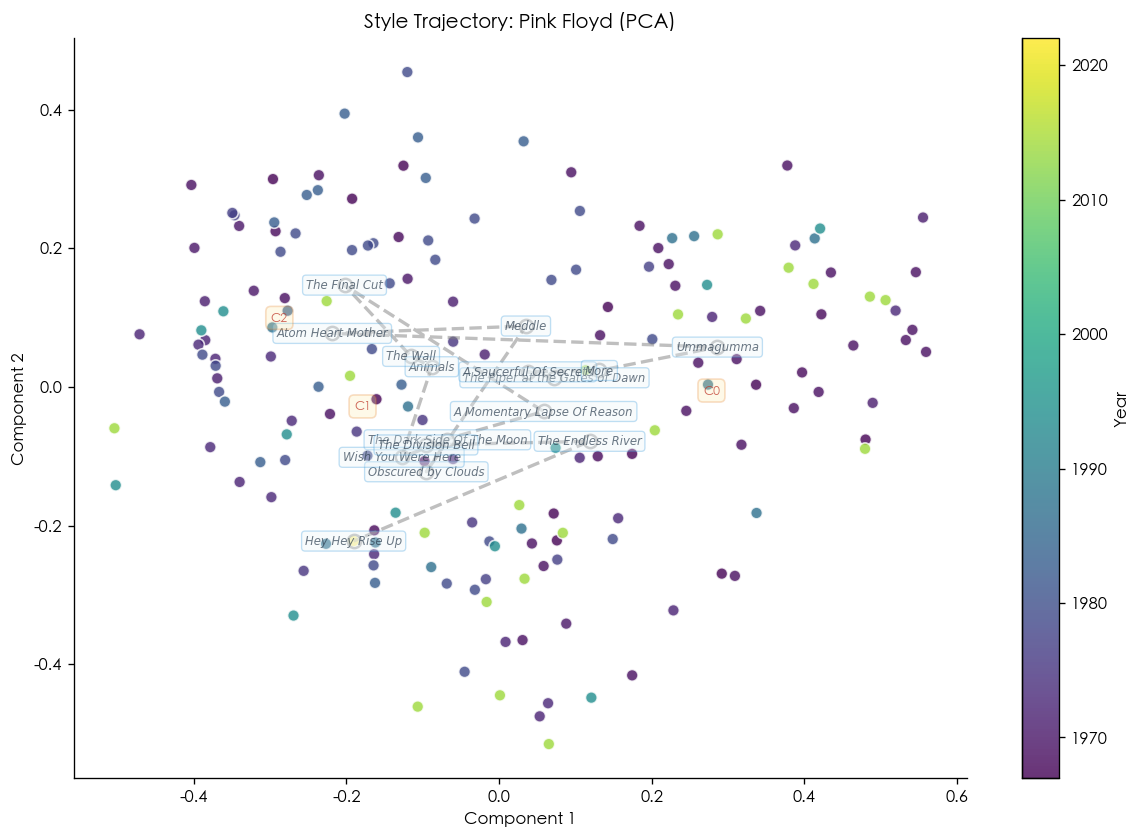

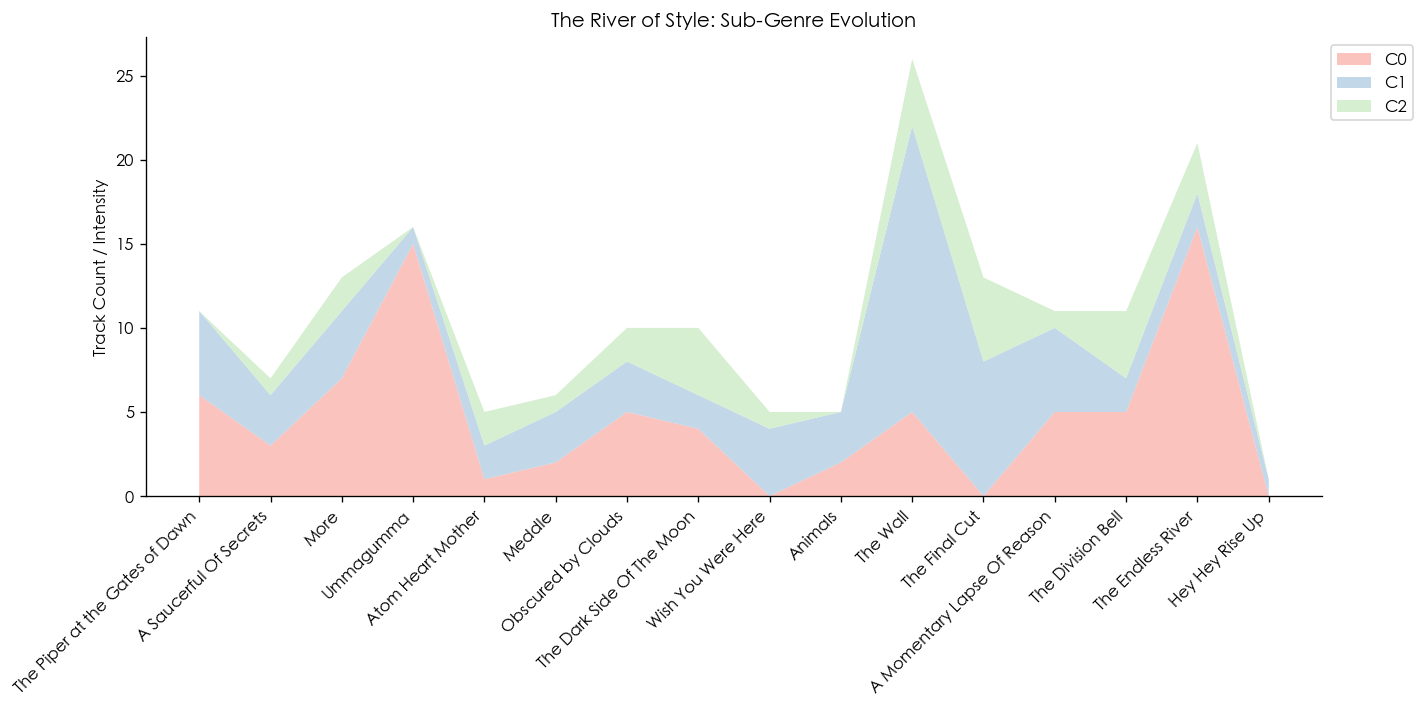

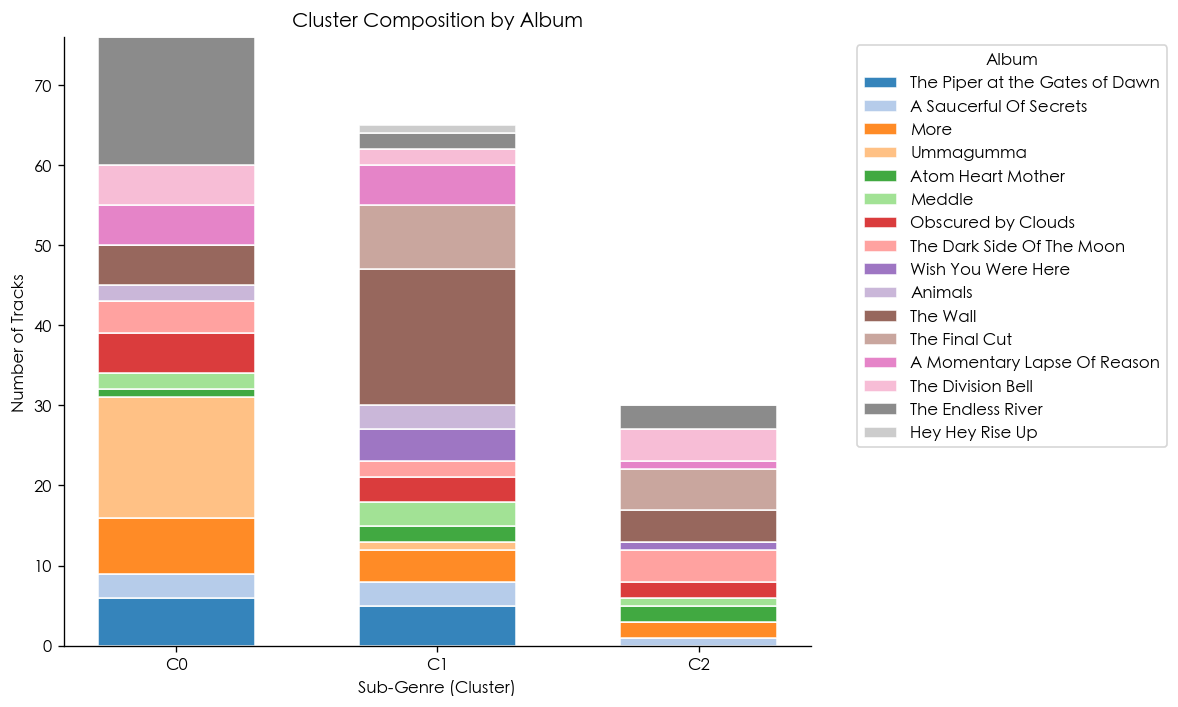

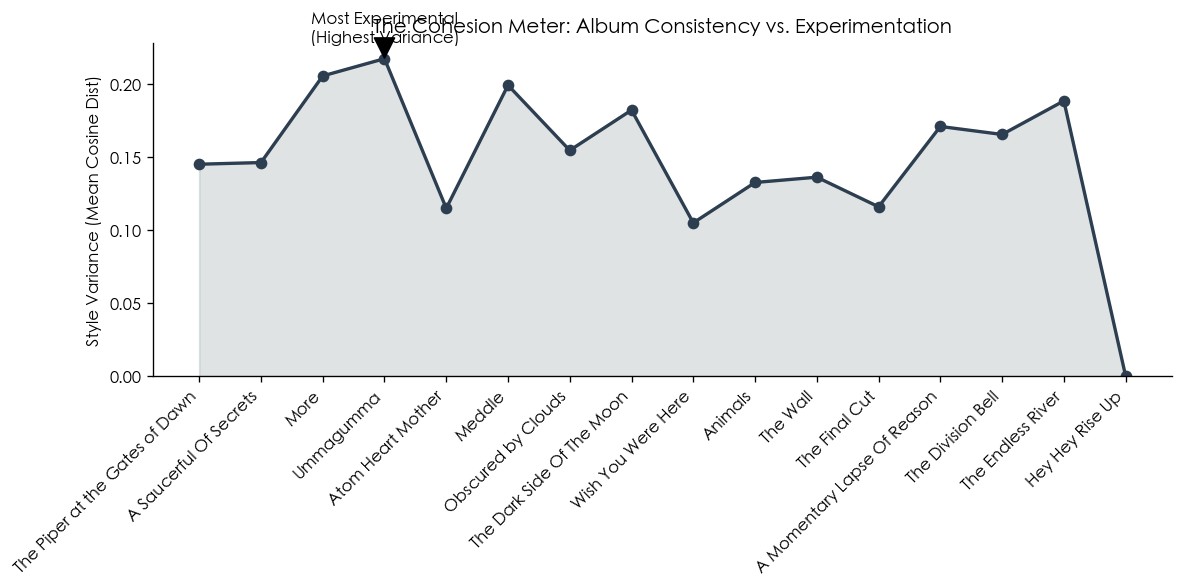

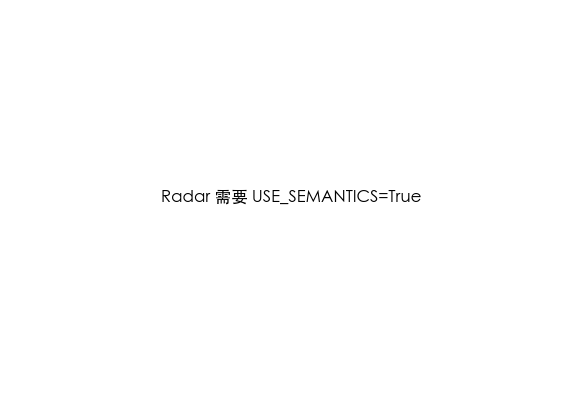

In [37]:
figs: list[tuple[str, plt.Figure]] = []

print("生成可视化图表...")

# 1) Trajectory
print("  1/5 Trajectory")
fig_traj = GenreTrajectoryVisualizer.plot_2d_trajectory(
    analyzer,
    method=METHOD,
    clusters=clusters,
    cluster_labels=plot_labels,
    show_album_contours=SHOW_ALBUM_CONTOURS,
)
figs.append(("trajectory", fig_traj))

# 2) Streamgraph
print("  2/5 Streamgraph")
fig_stream = CareerStoryteller.plot_streamgraph(analyzer, clusters, cluster_labels=plot_labels)
figs.append(("streamgraph", fig_stream))

# 3) Cluster Composition
print("  3/5 Cluster Composition")
fig_comp = CareerStoryteller.plot_cluster_composition(analyzer, clusters, cluster_labels=plot_labels)
figs.append(("cluster_composition", fig_comp))

# 4) Consistency
print("  4/5 Consistency")
fig_cons = CareerStoryteller.plot_consistency(analyzer)
figs.append(("consistency", fig_cons))

# 5) Radar（需要语义 mapper）
print("  5/5 Radar")
if RADAR_ALBUMS is None:
    if len(albums) >= 2:
        radar_albums = [albums[0], albums[-1]]
    else:
        radar_albums = albums
else:
    radar_albums = RADAR_ALBUMS

if analyzer.mapper is None:
    fig_radar = plt.figure(figsize=(6, 4))
    plt.text(0.5, 0.5, "Radar 需要 USE_SEMANTICS=True", ha="center", va="center")
    plt.axis("off")
else:
    fig_radar = CareerStoryteller.plot_radar(analyzer, radar_albums, tags=RADAR_TAGS)

figs.append(("radar", fig_radar))

print(f"\n✓ 所有 {len(figs)} 个图表生成完成")
[name for name, _ in figs]

## 6. 在 Notebook 中预览图表

In [38]:
# 显示所有图表
for name, fig in figs:
    fig.suptitle(f"{career.artist_name} — {name}", fontsize=14, y=1.02)
    plt.show()

## 7. 导出到一个 PDF（多页）

In [39]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

with PdfPages(OUTPUT_PDF) as pdf:
    # 封面页：参数与簇标签（可复现实验）
    cover = plt.figure(figsize=(11.69, 8.27))  # A4 landscape
    cover.suptitle("Genres in Genres — Export", fontsize=16)
    txt = [
        f"time: {datetime.datetime.now().isoformat(timespec='seconds')}",
        f"mode: {MODE}",
        f"artist: {career.artist_name}",
        f"tracks: {len(career.tracks)} | embeddings: {len(career.embeddings)} | albums: {len(albums)}",
        f"method: {METHOD}",
        f"auto_k: {AUTO_K} | K: {k}",
        f"show_album_contours: {SHOW_ALBUM_CONTOURS}",
        f"use_semantics: {USE_SEMANTICS}",
        f"radar_albums: {radar_albums}",
        f"radar_tags: {RADAR_TAGS}",
        "",
        "cluster labels:",
    ]
    for cid in sorted(rich_labels.keys()):
        txt.append(f"  - {rich_labels[cid]}")
    cover.text(0.02, 0.95, "\n".join(txt), va="top", family="monospace", fontsize=10)
    cover.tight_layout()
    pdf.savefig(cover)
    plt.close(cover)

    # 图表页
    for name, fig in figs:
        fig.suptitle(f"{career.artist_name} — {name}", fontsize=12)
        pdf.savefig(fig)
        plt.close(fig)

print(f"✓ 导出成功: {OUTPUT_PDF}")
print(f"  文件大小: {OUTPUT_PDF.stat().st_size / 1024:.1f} KB")

✓ 导出成功: /Users/audiofool/Projects/genres-in-genres/exports/library_Pink_Floyd_pca.pdf
  文件大小: 52.4 KB


## 8. （可选）批量实验：多组参数一次性导出

如果你想比较不同方法/不同 K，可以把下面的实验配置打开，然后一次性导出到一个 PDF。

In [40]:
# 批量实验配置（按需启用）
BATCH_MODE = False

if BATCH_MODE:
    EXPERIMENTS = [
        {"method": "pca", "k": 3, "show_album_contours": False},
        {"method": "tsne", "k": 3, "show_album_contours": False},
        {"method": "umap", "k": 4, "show_album_contours": True},
    ]
    
    batch_pdf = OUTPUT_DIR / f"batch_{career.artist_name.replace(' ', '_')}.pdf"
    
    print(f"批量实验模式：{len(EXPERIMENTS)} 组参数")
    
    with PdfPages(batch_pdf) as pdf:
        for idx, exp in enumerate(EXPERIMENTS, 1):
            method = exp["method"]
            k_val = exp["k"]
            show_contours = exp["show_album_contours"]
            
            print(f"  实验 {idx}/{len(EXPERIMENTS)}: {method} | K={k_val} | contours={show_contours}")
            
            clusters_batch = analyzer.cluster_songs(n_clusters=k_val)
            plot_labels_batch, _ = build_cluster_labels(analyzer, clusters_batch, top_k=5)
            
            f1 = GenreTrajectoryVisualizer.plot_2d_trajectory(
                analyzer,
                method=method,
                clusters=clusters_batch,
                cluster_labels=plot_labels_batch,
                show_album_contours=show_contours,
            )
            f1.suptitle(f"Trajectory — {method} | K={k_val} | contours={show_contours}")
            pdf.savefig(f1)
            plt.close(f1)
    
    print(f"✓ 批量实验导出成功: {batch_pdf}")
else:
    print("批量实验模式未启用（设置 BATCH_MODE = True 启用）")

批量实验模式未启用（设置 BATCH_MODE = True 启用）
